In [18]:
from google.colab import drive
drive.mount("/content/drive")
import os
path="/content/drive/MyDrive/Pytorch实现Word2Vec/model"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['record-50.log',
 '__pycache__',
 'GloveTrain.py',
 'WordEmbeddingDataset.py',
 'GloveModel.py',
 'Untitled0.ipynb']

In [19]:
import torch.utils.data as tud
import torch

class WordEmbeddingDataset(tud.Dataset):
    def __init__(self, co_matrix, weight_matrix):
        self.co_matrix = co_matrix
        self.weight_matrix = weight_matrix
        self.train_set = []

        for i in range(self.weight_matrix.shape[0]):
            for j in range(self.weight_matrix.shape[1]):
                if weight_matrix[i][j] != 0:
                    # 这里对权重进行了筛选，去掉权重为0的项
                    # 因为共现次数为0会导致log(X)变成nan
                    self.train_set.append((i, j))

    def __len__(self):
        '''
        必须重写的方法
        :return: 返回训练集的大小
        '''
        return len(self.train_set)

    def __getitem__(self, index):
        '''
        必须重写的方法
        :param index:样本索引
        :return: 返回一个样本
        '''
        (i, j) = self.train_set[index]
        return i, j, torch.tensor(self.co_matrix[i][j], dtype=torch.float), self.weight_matrix[i][j]


In [20]:
import torch
import torch.nn as nn  #神经网络工具箱torch.nn
import torch.nn.functional as F  #神经网络函数torch.nn.functional
import numpy as np
import sys
import math

class GloveModel(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size

        #声明v和w为Embedding向量
        self.v = nn.Embedding(vocab_size, embed_size)
        self.w = nn.Embedding(vocab_size, embed_size)
        self.biasv = nn.Embedding(vocab_size, 1)
        self.biasw = nn.Embedding(vocab_size, 1)

        #随机初始化参数
        initrange = 0.5 / self.embed_size
        self.v.weight.data.uniform_(-initrange, initrange)
        self.w.weight.data.uniform_(-initrange, initrange)

    def forward(self, i, j, co_occur, weight):
        vi = self.v(i)
        wj = self.w(j)
        bi = self.biasv(i)
        bj = self.biasw(j)

        similarity = torch.mul(vi, wj)
        similarity = torch.sum(similarity, dim=1)

        loss = similarity + bi + bj - torch.log(co_occur)
        loss = 0.5 * weight * loss * loss

        return loss.sum().mean()

    def gloveMatrix(self):
        '''
        获得词向量，这里把两个向量相加作为最后的词向量
        :return:
        '''
        return self.v.weight.data.cpu().numpy() + self.w.weight.data.cpu().numpy()


In [21]:
import torch
import torch.utils.data as tud  #Pytorch读取训练集需要用到torch.utils.data类

from collections import Counter
from sklearn.metrics.pairwise import  cosine_similarity

import pandas as pd
import numpy as np
import scipy

import time
import math
import random
import sys
import matplotlib.pyplot as plt


EMBEDDING_SIZE = 50
MAX_VOCAB_SIZE = 2000
WINDOW_SIZE = 5

NUM_EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 0.05

TEXT_SIZE = 20000000
LOG_FILE = "../logs/glove-{}.log".format(EMBEDDING_SIZE)
WEIGHT_FILE = "../weights/glove-{}.th".format(EMBEDDING_SIZE)

"""加载语料库"""
def getCorpus(filetype, size):
    if filetype == 'dev':
        filepath = '/content/drive/MyDrive/Pytorch实现Word2Vec/text8/text8.dev.txt'
    elif filetype == 'test':
        filepath = '/content/drive/MyDrive/Pytorch实现Word2Vec/text8/text8.test.txt'
    else:
        filepath = '/content/drive/MyDrive/Pytorch实现Word2Vec/text8/text8.train.txt'

    with open(filepath, "r") as f:
        text = f.read()
        text = text.lower().split()
        text = text[: min(len(text), size)]
        vocab_dict = dict(Counter(text).most_common(MAX_VOCAB_SIZE - 1))
        vocab_dict['<unk>'] = len(text) - sum(list(vocab_dict.values()))
        idx_to_word = list(vocab_dict.keys())
        word_to_idx = {word:ind for ind, word in enumerate(idx_to_word)}
        word_counts = np.array(list(vocab_dict.values()), dtype=np.float32)
        word_freqs = word_counts / sum(word_counts)
        print("Words list length:{}".format(len(text)))
        print("Vocab size:{}".format(len(idx_to_word)))
    return text, idx_to_word, word_to_idx, word_counts, word_freqs


# 计算共现矩阵

In [22]:
"""计算共现矩阵"""
def buildCooccuranceMatrix(text, word_to_idx):
    vocab_size = len(word_to_idx)
    maxlength = len(text)
    text_ids = [word_to_idx.get(word, word_to_idx["<unk>"]) for word in text]
    cooccurance_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    print("Co-Matrix consumed mem:%.2fMB" % (sys.getsizeof(cooccurance_matrix)/(1024*1024)))
    for i, center_word_id in enumerate(text_ids):
        window_indices = list(range(i - WINDOW_SIZE, i)) + list(range(i + 1, i + WINDOW_SIZE + 1))
        window_indices = [i % maxlength for i in window_indices]
        window_word_ids = [text_ids[index] for index in window_indices]
        for context_word_id in window_word_ids:
            cooccurance_matrix[center_word_id][context_word_id] += 1
        if (i+1) % 1000000 == 0:
            print(">>>>> Process %dth word" % (i+1))
    print(">>>>> Build co-occurance matrix completed.")
    return cooccurance_matrix



# 计算权重函数矩阵
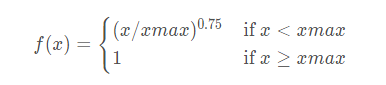

In [23]:
"""计算权重函数矩阵"""
def buildWeightMatrix(co_matrix):
    xmax = 100.0
    weight_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    print("Weight-Matrix consumed mem:%.2fMB" % (sys.getsizeof(weight_matrix) / (1024 * 1024)))
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            weight_matrix[i][j] = math.pow(co_matrix[i][j] / xmax, 0.75) if co_matrix[i][j] < xmax else 1
        if (i+1) % 1000 == 0:
            print(">>>>> Process %dth weight" % (i+1))
    print(">>>>> Build weight matrix completed.")
    return weight_matrix

In [24]:
def asMinutes(s):
    h = math.floor(s / 3600)
    s = s - h * 3600
    m = math.floor(s / 60)
    s -= m * 60
    return '%dh %dm %ds' % (h, m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def loadModel():
    path = WEIGHT_FILE
    model = GloveModel(MAX_VOCAB_SIZE, EMBEDDING_SIZE)
    model.load_state_dict(torch.load(path))
    return model



In [25]:
text, idx_to_word, word_to_idx, word_counts, word_freqs = getCorpus('train', size=TEXT_SIZE)    #加载语料及预处理
co_matrix = buildCooccuranceMatrix(text, word_to_idx)    #构建共现矩阵
weight_matrix = buildWeightMatrix(co_matrix)             #构建权重矩阵
dataset = WordEmbeddingDataset(co_matrix, weight_matrix) #创建dataset
dataloader = tud.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

Words list length:15304686
Vocab size:2000
Co-Matrix consumed mem:15.26MB
>>>>> Process 1000000th word
>>>>> Process 2000000th word
>>>>> Process 3000000th word
>>>>> Process 4000000th word
>>>>> Process 5000000th word
>>>>> Process 6000000th word
>>>>> Process 7000000th word
>>>>> Process 8000000th word
>>>>> Process 9000000th word
>>>>> Process 10000000th word
>>>>> Process 11000000th word
>>>>> Process 12000000th word
>>>>> Process 13000000th word
>>>>> Process 14000000th word
>>>>> Process 15000000th word
>>>>> Build co-occurance matrix completed.
Weight-Matrix consumed mem:15.26MB
>>>>> Process 1000th weight
>>>>> Process 2000th weight
>>>>> Build weight matrix completed.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GloveModel(MAX_VOCAB_SIZE, EMBEDDING_SIZE).to(device) #创建模型
#model = loadModel()
optimizer = torch.optim.Adagrad(model.parameters(), lr=LEARNING_RATE) #选择Adagrad优化器
model

GloveModel(
  (v): Embedding(2000, 50)
  (w): Embedding(2000, 50)
  (biasv): Embedding(2000, 1)
  (biasw): Embedding(2000, 1)
)

In [27]:
print_every = 10000
save_every = 50000
epochs = NUM_EPOCHS
iters_per_epoch = int(dataset.__len__() / BATCH_SIZE)
total_iterations = iters_per_epoch * epochs
print("Iterations: %d per one epoch, Total iterations: %d " % (iters_per_epoch, total_iterations))

start = time.time()
for epoch in range(epochs):
    loss_print_avg = 0
    iteration = iters_per_epoch * epoch
    for i, j, co_occur, weight in dataloader:
      i = i.long().to(device)
      j = j.long().to(device)        
      co_occur = co_occur.long().to(device)        
      weight = weight.long().to(device)  

      iteration += 1
      optimizer.zero_grad()   #每一批样本训练前重置缓存的梯度
      loss = model(i, j, co_occur, weight)    #前向传播
      loss.backward()     #反向传播
      optimizer.step()    #更新梯度
      loss_print_avg += loss.item()


      if iteration % print_every == 0:
          time_desc = timeSince(start, iteration / total_iterations)
          iter_percent = iteration / total_iterations * 100
          loss_avg = loss_print_avg / print_every
          loss_print_avg = 0
          print("epoch: %d, iter: %d/%d (%.4f%%), loss: %.5f, %s" %
                (epoch, iteration, total_iterations, iter_percent, loss_avg, time_desc))

#torch.save(model.state_dict(), WEIGHT_FILE)

Iterations: 41793 per one epoch, Total iterations: 417930 
epoch: 0, iter: 10000/417930 (2.3927%), loss: 1044.03065, 0h 0m 21s (- 0h 14m 53s)
epoch: 0, iter: 20000/417930 (4.7855%), loss: 178.83057, 0h 0m 43s (- 0h 14m 23s)
epoch: 0, iter: 30000/417930 (7.1782%), loss: 107.63227, 0h 1m 4s (- 0h 14m 0s)
epoch: 0, iter: 40000/417930 (9.5710%), loss: 80.43127, 0h 1m 26s (- 0h 13m 39s)
epoch: 1, iter: 50000/417930 (11.9637%), loss: 50.13434, 0h 1m 48s (- 0h 13m 19s)
epoch: 1, iter: 60000/417930 (14.3565%), loss: 51.94846, 0h 2m 10s (- 0h 12m 56s)
epoch: 1, iter: 70000/417930 (16.7492%), loss: 43.75499, 0h 2m 31s (- 0h 12m 33s)
epoch: 1, iter: 80000/417930 (19.1420%), loss: 37.72172, 0h 2m 53s (- 0h 12m 11s)
epoch: 2, iter: 90000/417930 (21.5347%), loss: 20.26973, 0h 3m 15s (- 0h 11m 50s)
epoch: 2, iter: 100000/417930 (23.9275%), loss: 29.18328, 0h 3m 36s (- 0h 11m 28s)
epoch: 2, iter: 110000/417930 (26.3202%), loss: 26.74294, 0h 3m 58s (- 0h 11m 7s)
epoch: 2, iter: 120000/417930 (28.7129%)

# 实验结果
## 利用余弦相似性衡量向量之间的相似性

In [28]:
def find_nearest(word, embedding_weights):
    index = word_to_idx[word]
    embedding = embedding_weights[index]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in embedding_weights])
    return [idx_to_word[i] for i in cos_dis.argsort()[:10]]


In [29]:
glove_matrix = model.gloveMatrix()
for word in ["good", "one", "green", "like", "america", "queen", "better", "paris", "work", "computer", "language"]:
    print(word, find_nearest(word, glove_matrix))

good ['good', 'evil', 'bad', 'question', 'hard', 'sign', 'normal', 'better', 'word', 'real']
one ['one', 'nine', 'zero', 'two', 'three', 'eight', 'six', 'seven', 'four', 'five']
green ['green', 'blue', 'organization', 'domain', 'generation', 'celtic', 'airport', 'industrial', 'largest', 'station']
like ['like', 'particular', 'something', 'having', 'just', 'them', 'any', 'believe', 'same', 'called']
america ['america', 'north', 'africa', 'europe', 'asia', 'central', 'parliament', 'east', 'throughout', 'south']
queen ['queen', 'department', 'israeli', 'captain', 'congress', 'domestic', 'celtic', 'violence', 'arab', 'golden']
better ['better', 'hard', 'greater', 'makes', 'rather', 'normal', 'significant', 'call', 'without', 'special']
paris ['paris', 'asian', 'boston', 'won', 'controversy', 'spain', 'speaking', 'philosopher', 'twenty', 'captain']
work ['work', 'the', 'where', '<unk>', 'position', 'him', 'himself', 'and', 'democracy', 'both']
computer ['computer', 'software', 'hardware', '

## 利用向量之间的运算考察词向量的关联性

In [30]:
def findRelationshipVector(word1, word2, word3):
    word1_idx = word_to_idx[word1]
    word2_idx = word_to_idx[word2]
    word3_idx = word_to_idx[word3]
    embedding = glove_matrix[word2_idx] - glove_matrix[word1_idx] + glove_matrix[word3_idx]
    cos_dis = np.array([scipy.spatial.distance.cosine(e, embedding) for e in glove_matrix])
    for i in cos_dis.argsort()[:5]:
        print("{} to {} as {} to {}".format(word1, word2, word3, idx_to_word[i]))

In [31]:
findRelationshipVector('man', 'king', 'woman')
findRelationshipVector('america', 'washington', 'france')
findRelationshipVector('good', 'better', 'little')

man to king as woman to king
man to king as woman to rd
man to king as woman to last
man to king as woman to iv
man to king as woman to summer
america to washington as france to j
america to washington as france to swedish
america to washington as france to iv
america to washington as france to composer
america to washington as france to philosopher
good to better as little to little
good to better as little to uses
good to better as little to exists
good to better as little to longer
good to better as little to just


## 利用SVD进行词向量的降维并可视化显示
可能是没有训练好，修改了batch_size的大小

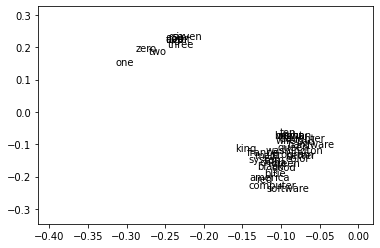

In [32]:
#数据降维以及可视化
candidate_words = ['one','two','three','four','five','six','seven','eight','night','ten','color','green','blue','red','black',
                    'man','woman','king','queen','wife','son','daughter','brown','zero','computer','hardware','software','system','program',
                    'america','china','france','washington','good','better','bad']
candidate_indexes = [word_to_idx[word] for word in candidate_words]
choosen_indexes = candidate_indexes
choosen_vectors = [glove_matrix[index] for index in choosen_indexes]

U, S, VH = np.linalg.svd(choosen_vectors, full_matrices=False)
for i in range(len(choosen_indexes)):
    plt.text(U[i, 0], U[i, 1], idx_to_word[choosen_indexes[i]])

coordinate = U[:, 0:2]
plt.xlim((np.min(coordinate[:, 0]) - 0.1, np.max(coordinate[:, 0]) + 0.1))
plt.ylim((np.min(coordinate[:, 1]) - 0.1, np.max(coordinate[:, 1]) + 0.1))
plt.show()

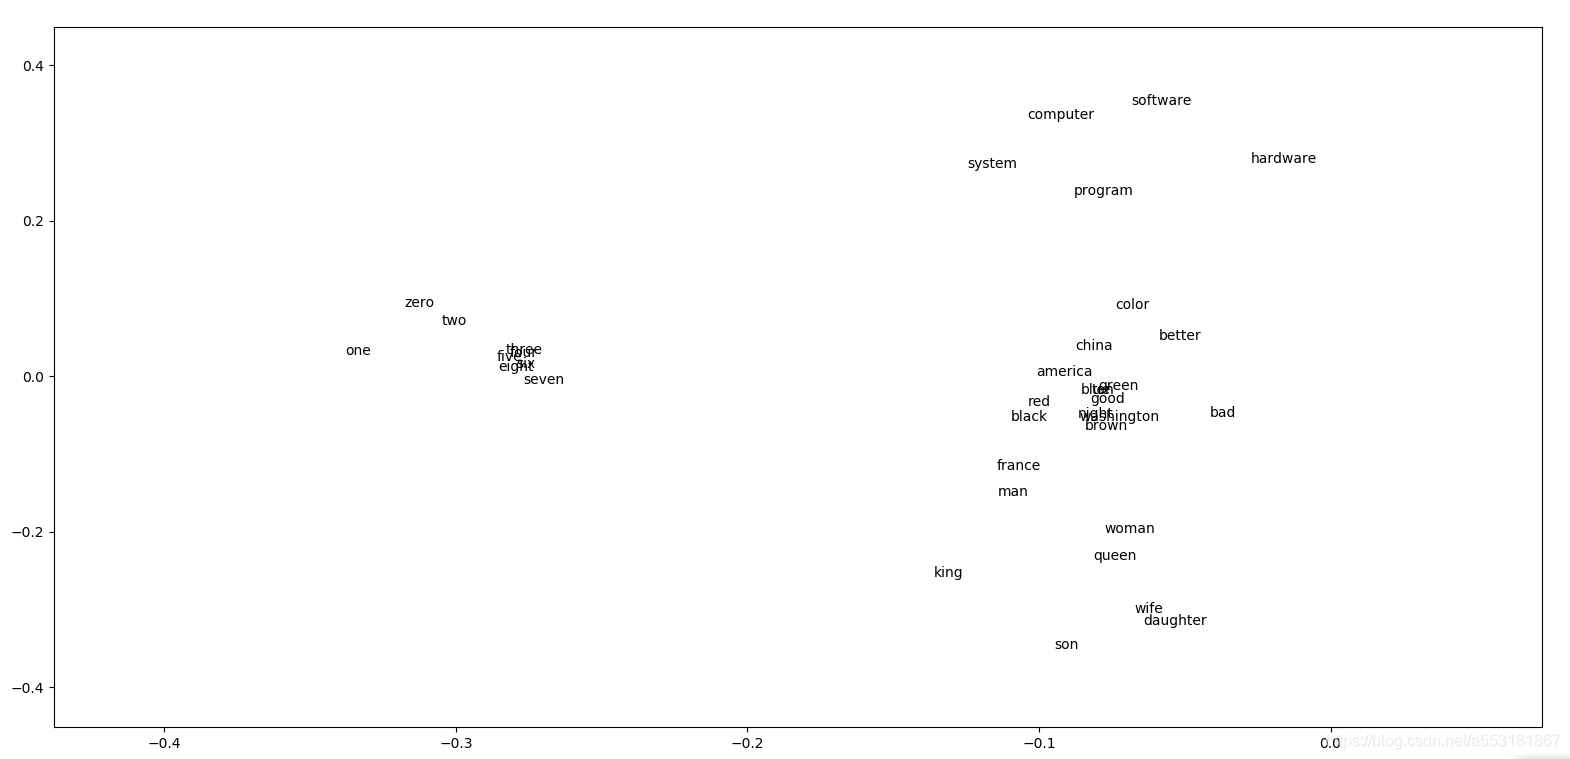